In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [244]:
# #weather data preprocessing (for colusa county, few fires)

# #cols to keep, that have >2000 samples
# selected_col_labels = ['Station', 'Date', 'Time', 'Interval', 'Air max', 'Air max time',
#        'Air min', 'Air obs', 'Air3 avg', 'RH max time', 'RH min time',
#        'Soil avg', 'Precip', 'ETo', 'Leaf3', 'Wind max dir', 'Wind max speed',
#        'Battery', 'Hrs 26F', 'Hrs 28F', 'HR65TO75FA90RH3']
# #all col labels
# col_labels = ["Station","Date","Time","Interval","Air max","Air max time","Air min",
#               "Air min time","Air obs","Air avg","Air2 max","Air2 max time","Air2 min",
#               "Air2 min time","Air2 obs","Air2 avg","Air3 max","Air3 max time","Air3 min",
#               "Air3 min time","Air3 obs","Air3 avg","RH max","RH max time","RH min",
#               "RH min time","RH avg","RH2 max","RH2 max time","RH2 min","RH2 min time",
#               "RH2 avg","RH3 max","RH3 max time","RH3 min","RH3 min time","RH3 avg",
#               "Soil max","Soil max time","Soil min","Soil min time","Soil obs","Soil avg",
#               "Precip","ETo","Solar","Leaf","Leaf2","Leaf3","Wind max dir","Wind max speed",
#               "Wind max time","Wind obs dir","Wind obs speed","Wind avg dir","Wind avg speed",
#               "Wind ST","Wind run","Battery","Dew pnt","Chill hrs","Hrs 26F","Hrs 28F","Hrs 32F",
#               "DD41F","DD41F2","DD41F3","TC DSV","TC DSV2","TC DSV3","HR65TO75FA90RH","HR65TO75FA90RH2",
#               "HR65TO75FA90RH3","BEEHOURS","BEESEASON"]

# weather_df = pd.read_csv("Colusa Weather Data.csv", na_values=[' ', ''])
# weather_df = weather_df.dropna(axis=1, thresh=2000)
# correct_selected_col_labels_dict = dict(zip(selected_col_labels, [col_labels[col_labels.index(s) + 1] for s in selected_col_labels]))
# weather_df = weather_df.rename(columns=correct_selected_col_labels_dict)
# remove_cols = ['BEEHOURS']
# weather_df = weather_df.drop(columns=remove_cols)
# #print(weather_df.columns)
# display(weather_df)




In [245]:
#fire data preprocessing
fires_df = pd.read_csv("mapdataall.csv")
#print(len(fires_df))
riverside_fires = fires_df[fires_df['incident_county'] == 'Riverside']
riverside_fire_dates = riverside_fires['incident_date_created'].apply(lambda x: x.split('T')[0])
#print(riverside_fire_dates)
#print(len(riverside_fires))

#balance dataset
#try removing incomplete rows


In [246]:
#weather data preprocessing

# Description below generated by chatGPT
# FEW (Few): 1/8 to 2/8 of the sky covered by clouds.
# SCT (Scattered): 3/8 to 4/8 of the sky covered by clouds.
# BKN (Broken): 5/8 to 7/8 of the sky covered by clouds.
# OVC (Overcast): 8/8 of the sky covered by clouds.


cloud_cover_codes = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

weather_df = pd.read_csv("Riverside Weather Data.csv", na_values=[' ', ''])
weather_df = weather_df.dropna(axis=1, thresh=20000)
remove_cols = ['REPORT_TYPE', 'SOURCE', 'HourlyAltimeterSetting', 'REM', 'REPORT_TYPE.1', 'SOURCE.1', 'WindEquipmentChangeDate']
weather_df = weather_df.drop(columns=remove_cols)
for column_name in list(weather_df.columns): 
    if isinstance(weather_df[column_name][0], str): 
        weather_df[column_name] = weather_df[column_name].str.rstrip('s')

#cloud cover processing
cloud_df = weather_df['HourlySkyConditions']
cloud_cover_list = []
for condition in cloud_df.to_list():
    #print(condition)
    if isinstance(condition, str) and condition[0:3] in cloud_cover_codes: #check that entry is not NaN
        cloud_cover_list.append(float(condition.split(':')[1][0:2])/8.0)
    else:
        cloud_cover_list.append(np.nan) #mark NaN values with -1

cloud_cover_df = pd.DataFrame(cloud_cover_list, columns=['cloud cover percentage'])
#cloud_height_range_df =
weather_df = pd.concat([weather_df, cloud_cover_df], axis=1).drop(columns=['HourlySkyConditions'])
display(weather_df)
convert_cols = ['HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 
                'HourlyPressureChange', 'HourlyPressureTendency', 'HourlyRelativeHumidity', 
                'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 
                'HourlyWetBulbTemperature', 'HourlyWindDirection', 'HourlyWindSpeed', 
                'cloud cover percentage']

weather_df = weather_df.replace('\D', '', regex=True)
weather_df = weather_df.replace('', np.nan)
weather_df = weather_df.fillna(0.0)

#guessed important vars

print(len(weather_df))

for convert_col in convert_cols:
    weather_df[convert_col] = weather_df[convert_col].astype(float)

#we need to convert from strings to floats before interpolating
weather_df = weather_df[weather_df['DATE'].str[8:10] == '12']  #only take one sample at ~midday every day by dropping other rows
important_vars = [#'HourlyDryBulbTemperature', 'HourlyPrecipitation', 
                'HourlyRelativeHumidity',   
                'HourlyWindSpeed']
weather_df = weather_df.drop(columns=set(convert_cols).difference(set(important_vars)))

display(weather_df)

C:\Users\Isaac\AppData\Local\Temp\ipykernel_24456\2292833007.py:12: DtypeWarning: Columns (21,27,28,29,30,31,37,38,49,50,54,56,57,59,60,62,64,116,118,123) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df = pd.read_csv("Riverside Weather Data.csv", na_values=[' ', ''])


,STATION,DATE,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindSpeed,cloud cover percentage
0,72286903171,2016-01-01T00:53:00,12,48,0.00,0.02,8.0,23.0,30.07,29.21,10.00,35.0,060,7.0,0.0
1,72286903171,2016-01-01T01:53:00,12,49,0.00,NaN,NaN,22.0,30.07,29.21,10.00,36.0,050,8.0,0.0
2,72286903171,2016-01-01T02:53:00,13,46,0.00,NaN,NaN,26.0,30.07,29.21,10.00,34.0,080,6.0,0.0
3,72286903171,2016-01-01T03:53:00,12,47,0.00,0.01,8.0,24.0,30.06,29.19,10.00,35.0,070,8.0,0.0
4,72286903171,2016-01-01T04:53:00,13,45,0.00,NaN,NaN,27.0,30.07,29.20,10.00,34.0,080,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80674,72286903171,2023-12-01T19:53:00,41,54,NaN,NaN,NaN,62.0,30.04,29.18,10.00,48.0,080,3.0,0.0
80675,72286903171,2023-12-01T20:53:00,41,52,NaN,NaN,NaN,66.0,30.05,29.19,10.00,47.0,070,3.0,0.0
80676,72286903171,2023-12-01T21:53:00,40,50,NaN,-0.05,3.0,68.0,30.08,29.21,10.00,45.0,000,0.0,0.0
80677,72286903171,2023-12-01T22:53:00,40,49,NaN,NaN,NaN,71.0,30.07,29.21,10.00,45.0,050,5.0,0.0


80679


,STATION,DATE,HourlyRelativeHumidity,HourlyWindSpeed
12,72286903171,20160101125300,14.0,5.0
37,72286903171,20160102125300,15.0,0.0
62,72286903171,20160103125300,35.0,10.0
87,72286903171,20160104125300,36.0,3.0
122,72286903171,20160105122100,90.0,5.0
...,...,...,...,...
80546,72286903171,20231127125300,16.0,10.0
80571,72286903171,20231128125300,20.0,11.0
80596,72286903171,20231129125300,43.0,8.0
80631,72286903171,20231130125300,60.0,0.0


168
336


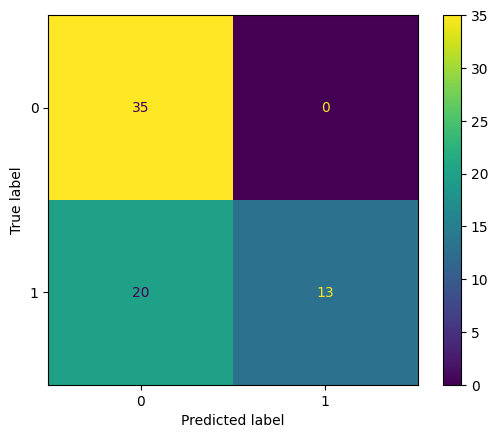

In [247]:
riverside_fire_dates = list(riverside_fire_dates)
riverside_fire_dates = [s.replace('-', '') for s in riverside_fire_dates]
#print(riverside_fire_dates)
Y = []
for date in weather_df['DATE']:
    #print(date)
    value = True if date[0:8] in riverside_fire_dates else False
    Y.append(value)
print(len([s for s in Y if s == True]))
Y = np.array(Y)

weather_df['is_fire'] = Y

#downsampling 
#code from chatgpt

# Separate the DataFrame into two based on the boolean column
true_values = weather_df[weather_df['is_fire'] == True]
false_values = weather_df[weather_df['is_fire'] == False]

# Downsample the larger group to match the size of the smaller group
min_size = min(len(true_values), len(false_values))
downsampled_true = true_values.sample(n=min_size, random_state=42)
downsampled_false = false_values.sample(n=min_size, random_state=42)

# Concatenate the downsampled DataFrames
weather_df = pd.concat([downsampled_true, downsampled_false])

# # Shuffle the rows in the resulting DataFrame
# weather_df = weather_df.sample(frac=1, random_state=42).reset_index(drop=True)

#\code from chatgpt

print(len(weather_df))

#more data processing
drop_label_cols = ['STATION', 'DATE']
weather_df_with_dates = copy.copy(weather_df)
weather_df = weather_df.drop(columns=drop_label_cols)

#display(weather_df)



X = weather_df
#display(X)
X_train, X_test, y_train, y_test = train_test_split(X, X['is_fire'], test_size=0.2)

#use a scitkit learn scaler so that we can use it later for new data points:
scaler_input = StandardScaler()
scaler_input.fit(X_train)
data_scaled_train = scaler_input.transform(X_train)
data_scaled_test = scaler_input.transform(X_test)

#put the scaled data back into a dataframe
data_scaled_train = pd.DataFrame(data_scaled_train)
data_scaled_train.index = X_train.index
mapcols = {}
for idx in range(len(X_train.columns)):
    mapcols[idx] = X_train.columns[idx]
X_train = data_scaled_train.rename(columns=mapcols)

data_scaled_test = pd.DataFrame(data_scaled_test)
data_scaled_test.index = X_test.index
mapcols = {}
for idx in range(len(X_test.columns)):
    mapcols[idx] = X_test.columns[idx]
X_train = data_scaled_test.rename(columns=mapcols)

model = LogisticRegression()


# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data (probabilities)
y_pred = model.predict(X_test)


# Extract the probability of belonging to class 1
prob_class_1 = dict(zip([s[0:8] for s in weather_df_with_dates['DATE'].tolist()], y_proba[:, 0]))
#print(prob_class_1)
#print(np.mean(np.array(y_proba[:,0])))
actual_fire_probs = [s[1] for s in prob_class_1.items() if s[0] in riverside_fire_dates]
#print(np.mean(actual_fire_probs))
conf_mat = confusion_matrix(y_pred=y_pred, y_true=y_test)
conf_mat_display = ConfusionMatrixDisplay(conf_mat)
conf_mat_display.plot()
#print([prob_class_1.get(s) for s in riverside_fire_dates[30:]])

In [248]:
# df = pd.read_csv("mapdataall.csv")
# months = df["incident_date_created"].str.slice(5,7)
# days = df["incident_date_created"].str.slice(8,10)
# counts = months.value_counts()
# #print(counts)
# ##code from chatgpt
# # Use zip to pair elements from both lists
# zipped_lists = list(zip(counts.index, counts))

# # Sort the zipped list based on the values from list1
# sorted_zipped_lists = sorted(zipped_lists, key=lambda x: x[0])

# # Extract the sorted elements back into separate lists
# indices, sorted_counts = zip(*sorted_zipped_lists)
# ##\code from chatgpt
# plt.plot(indices, sorted_counts)